Run model and write output netcdf files that are specified in the .ini file. The output files can be specified in the [reportingOptions] section of the .ini file (e.g. setup_05_non-natural.ini).

In the first codecells the packages required for the simulation and analysis are imported the pcrglobwb model is imported and initialised as a test to see if the model is working as it should all the output values and modeltimestep information is retrieved to see if the model is initialsed correctly.

In [3]:
#Import docker and set client
import docker
client = docker.from_env()

In [4]:
#Packages required for the simulation and analysis 
import os
import time
import datetime
import cftime
from datetime import datetime
from datetime import timedelta

import numpy
import numpy.ma as ma
import pandas as pd
import xarray as xr

import hydrostats.data as hd
import hydrostats.visual as hv
import matplotlib.pyplot as plt

import HydroErr as he
import numpy as np

from ewatercycle.parametersetdb import build_from_urls
from ewatercycle.observation.grdc import get_grdc_data


In [5]:
#Run docker container that contains model
from grpc4bmi.bmi_client_docker import BmiClientDocker
pcrg = BmiClientDocker(image='ewatercycle/pcrg-grpc4bmi:latest', image_port=55555, 
                       input_dir="/mnt/home/user35/pcrglob/input", 
                       output_dir="/mnt/home/user35/pcrglob/output")

In [6]:
pcrg.get_component_name()

'pcrglobwb'

In [7]:
#Read the .ini file and initialize the model
%time pcrg.initialize('pcrglob_05min_Merrimack.ini')

CPU times: user 9.71 ms, sys: 4.08 ms, total: 13.8 ms
Wall time: 31.6 s


In [8]:
#Retrieve the ouput variable names, these variables can be retrieved for each timestep
pcrg.get_output_var_names()

('groundwater_recharge',
 'lake_and_reservoir_storage',
 'domesticWaterConsumptionVolume',
 'land_surface_actual_evaporation',
 'groundwater_storage',
 'snow_melt',
 'totalPotentialMaximumGrossDemand',
 'interception_evaporation',
 'flood_innundation_depth',
 'total_groundwater_abstraction',
 'water_body_actual_evaporation',
 'interflow',
 'consumptive_water_use_for_irrigation_demand',
 'non_irrigation_gross_demand_volume',
 'accumulated_total_surface_runoff',
 'livestock_water_withdrawal',
 'land_surface_potential_evaporation',
 'total_groundwater_storage',
 'bare_soil_evaporation',
 'top_water_layer_evaporation',
 'transpiration_from_irrigation',
 'total_thickness_of_active_water_storage',
 'domestic_water_withdrawal',
 'netLqWaterToSoil_at_irrigation_volume',
 'interception_storage',
 'non_irrigation_gross_demand',
 'livestockWaterConsumptionVolume',
 'groundwater_depth_for_top_layer',
 'surface_water_storage',
 'irrigation_gross_demand_volume',
 'return_flow_from_irrigation_demand_

In [9]:
#Retrieve modeltimestep information
tunit = pcrg.get_time_units()

current_date = cftime.num2date(pcrg.get_current_time(),tunit).date()
start_date = cftime.num2date(pcrg.get_start_time(),tunit).date()
end_date = cftime.num2date(pcrg.get_end_time(),tunit).date()
print(start_date, end_date)

2002-01-01 2016-12-31


### Evolve the model and capture variable discharge

In the following codecells the variables of our choice are defined and arrays are made to save these values over the model run. The startdate, enddate and time per step are also retrieved from the model. The amount of timesteps over which the mode is run is also defined and the last step required to perform the model run is to make an empty dataset in which to store the results. 

In [10]:
variable = 'discharge'
variable2 = 'total_evaporation'          

In [11]:
vals = pcrg.get_value(variable)
unit = pcrg.get_var_units(variable)
vals2 = pcrg.get_value(variable2) 
unit2 = pcrg.get_var_units(variable2) 
shape = pcrg.get_grid_shape(pcrg.get_var_grid(variable))
grid_id = pcrg.get_var_grid(variable)

lon = pcrg.get_grid_x(grid_id)
lat = pcrg.get_grid_y(grid_id)

In [12]:
tstart = int(pcrg.get_start_time())
tend = int(pcrg.get_end_time())
tstep = int(pcrg.get_time_step())
tstep_nmbr = (tend - tstart) / tstep
print(tstart, tend, tstep)

36890 42368 1


In [13]:
# The model is run over 10 years, 
tstep_nmbr = 3650

In [14]:
#Create xarray dataset with coordinates and time series
ds = xr.Dataset(coords={'lon': lon,
                        'lat': lat,
                        'time': pd.date_range(start_date, periods=tstep_nmbr)})
ds

<xarray.Dataset>
Dimensions:  (lat: 54, lon: 54, time: 5)
Coordinates:
  * lon      (lon) float64 40.54 40.63 40.71 40.79 40.88 40.96 41.04 41.13 ...
  * lat      (lat) float64 -73.46 -73.38 -73.29 -73.21 -73.13 -73.04 -72.96 ...
  * time     (time) datetime64[ns] 2002-01-01 2002-01-02 2002-01-03 ...
Data variables:
    *empty*

In [15]:
#Create empty array for faster filling
data_variable = np.zeros(shape=(len(lon), len(lat), 0))
data_variable2 = np.zeros(shape=(len(lon), len(lat), 0)) 
data_variable.shape

(54, 54, 0)

In the below codecell the model is run over the defined timesteps

In [16]:
#Model run with retrieval of variables for each time step

for idx, i in enumerate(range(int(tstep_nmbr))):
    
    print(i)
    
    pcrg.update_until(tstart + i *tstep)
    vals = pcrg.get_value(variable)
    vals2 = pcrg.get_value(variable2)
    data = np.reshape(vals, (len(lon), len(lat)))
    data2 = np.reshape(vals2, (len(lon), len(lat)))
    data_variable = np.dstack((data_variable, data))
    data_variable2 = np.dstack((data_variable2, data2))

0
1
2
3
4


Now the simulation is performd the gained data is stored in a usefull format. It can be than be used to plot a map of the discharge. The location of the red dot marks the location of the GRDC station allong the Merrimack river.

In [17]:
#Append variable data to xarray dataset
ds[variable] = (('lon', 'lat', 'time'), data_variable)
ds[variable2] = (('lon', 'lat', 'time'), data_variable2)


# record data to file
ds.to_netcdf('/mnt/home/user35/output_pcrglobwb_evap_discharge.nc')

m3.s-1


<xarray.Dataset>
Dimensions:            (lat: 54, lon: 54, time: 5)
Coordinates:
  * lon                (lon) float64 40.54 40.63 40.71 40.79 40.88 40.96 ...
  * lat                (lat) float64 -73.46 -73.38 -73.29 -73.21 -73.13 ...
  * time               (time) datetime64[ns] 2002-01-01 2002-01-02 ...
Data variables:
    discharge          (lon, lat, time) float64 nan nan nan nan nan nan nan ...
    total_evaporation  (lon, lat, time) float64 nan nan nan nan nan nan nan ...

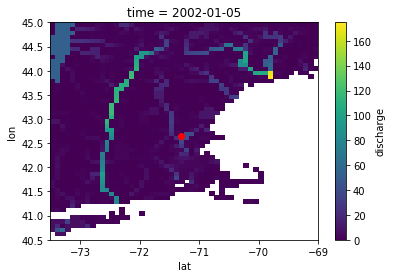

In [18]:
#Plot variable map of time step 4
array = ds[variable].isel(time= 4) 
array.plot()
plt.plot(-71.2984, 42.6459, 'ro') #Location of the GRDC station
print(unit)
ds

Now the simulation is performed and with the means of a plot we have verified that the results are 'logical'. The simulation will now be compared to the observations of the GRDC station. For this comparison the discharge as calculated by the model at the location of the GRDC station is saved to a different array. The GRDC data is imported as another array and both arrays are than used to determine the NSE, KGE and plot a hydrograph with the help of the hydrostats package.

In [19]:
# Select timeseries based on lat lon of GRDC station
timeseries = ds[variable].sel(lat=-71.2984, lon=42.6459, method= 'nearest')

sim = timeseries.to_dataframe()

In [20]:
station_id = '4147380' 
observations = get_grdc_data(station_id, str(start_date), str(end_date))
obs_df = observations.to_dataframe()
sim["observation"] = obs_df["streamflow"]
sim = sim.drop(columns=['lat', 'lon'])
simnso = sim.iloc[365:] # The first year of the simulation is disregarded and consider a spin up period.

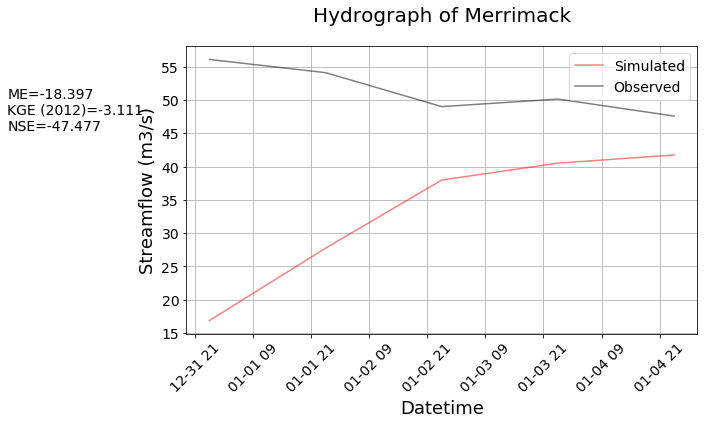

In [21]:
hv.plot(simnso[['discharge', 'observation']],
title='Hydrograph of Merrimack',
linestyles=['r-', 'k-'],
legend=('Simulated', 'Observed'),
labels=['Datetime', 'Streamflow (m3/s)'],
metrics=['ME', 'KGE (2012)','NSE'],
grid=True)
plt.show()

With the simulations and analysis performed the model is closed and the pcrg instance is deleted

In [22]:
#Write output files and close model
pcrg.finalize()

In [23]:
#Remove pcrg
del pcrg